### Metodología


Con el objetivo de hacer un analisis a nivel semanal se sumo las ventas de cada producto por semana y se hizo un analisis sobre esos datos.

In [ ]:
import pandas as pd # Import the pandas library and assign it the alias 'pd'

# Leer el archivo Excel (primera hoja por defecto)
df_tiempo_vida = pd.read_csv("/content/Tiempo_vida.csv")

# Mostrar las primeras filas del DataFrame
print(df_tiempo_vida.head())

   Sku   Precio     Costo   TiempoVida  TamañoSurtido
0    1   $41.98    $23.70           28              1
1    2   $34.27    $22.63           28              1
2    3   $35.43    $20.44           21              6
3    4   $34.95    $19.91           28              1
4    5   $43.41    $27.26           14              1


In [ ]:
df_tiempo_vida.columns

Index(['Sku', ' Precio ', ' Costo ', 'TiempoVida', 'TamañoSurtido'], dtype='object')

In [ ]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt


### Segundo bloque de pruebas, se divide entre entrenamiento y test y se optimiza $\alpha$

In [ ]:
# ----------------------------------------------------------------------------
# 1. Limpieza de columnas " Precio ", " Costo " para convertir a float y renombrar
# ----------------------------------------------------------------------------

def limpiar_columnas_precio_costo(df_tiempo_vida):
    """
    Toma un DataFrame con columnas ' Precio ' y ' Costo ' en formato '$xx.xx'
    y las transforma en 'Precio' y 'Costo' numéricos (float).
    """
    # Renombrar columnas con espacios
    df_tiempo_vida.rename(columns={" Precio ": "Precio", " Costo ": "Costo"}, inplace=True)

    # Quitar el signo '$' y convertir a float
    df_tiempo_vida["Precio"] = df_tiempo_vida["Precio"].str.replace("$", "", regex=False).astype(float)
    df_tiempo_vida["Costo"]  = df_tiempo_vida["Costo"].str.replace("$", "", regex=False).astype(float)

    return df_tiempo_vida

In [ ]:

# ----------------------------------------------------------------------------
# 2. Convertir ventas semanales a ventas diarias (distribución uniforme)
# ----------------------------------------------------------------------------

def expandir_a_diario(df_ventas, columnas_semanales):
    """
    Convierte las ventas semanales (columnas del tipo '2022-01') a
    ventas diarias (por ejemplo '2022-01_d1', '2022-01_d2', ..., '_d7').
    Se asume distribución uniforme de la venta semanal sobre 7 días.

    Retorna:
    - df_ventas_diarias: DataFrame con columnas diarias
      (Sku, 2022-01_d1, 2022-01_d2, ..., 2022-01_d7, 2022-02_d1, etc.)
    - lista_columnas_diarias: lista con el nombre de las columnas generadas
      en orden cronológico.
    """
    df_expanded = df_ventas[["Sku"]].copy()
    lista_columnas_diarias = []

    # Usamos un diccionario para evitar el warning de fragmentación
    columnas_nuevas = {}

    for col_sem in columnas_semanales:
        for d in range(1, 8):  # 1..7 (días de la semana)
            col_day = f"{col_sem}_d{d}"
            columnas_nuevas[col_day] = df_ventas[col_sem] / 7.0  # Distribuir uniformemente
            lista_columnas_diarias.append(col_day)

    # Convertimos el diccionario en DF y concatenamos
    df_nuevo = pd.DataFrame(columnas_nuevas)
    df_ventas_diarias = pd.concat([df_expanded, df_nuevo], axis=1)

    return df_ventas_diarias, lista_columnas_diarias

In [ ]:

# ----------------------------------------------------------------------------
# 3. Funciones auxiliares (redondear al surtido, cálculo de promedio móvil)
# ----------------------------------------------------------------------------

def redondear_al_surtido(cantidad, tamanio_surtido):
    """Redondea hacia arriba al múltiplo más cercano de tamanio_surtido."""
    if cantidad <= 0:
        return 0
    return int(math.ceil(cantidad / tamanio_surtido) * tamanio_surtido)

def calcular_promedio_movil(ventas_history, sku, dia_actual_idx, N_semanas, columnas_diarias):
    """
    Calcula el promedio de demanda en las últimas N_semanas,
    equivalentes a (N_semanas * 7) días, para un SKU.

    - ventas_history: DataFrame con ventas diarias.
    - sku: identificador del producto.
    - dia_actual_idx: posición en la lista de columnas_diarias (0, 1, 2, ...)
    - N_semanas: número de semanas para el promedio.
    - columnas_diarias: lista ordenada de las columnas diarias.

    Retorna el valor promedio (float).
    """
    dias_a_revisar = N_semanas * 7
    idx_inicial = max(0, dia_actual_idx - dias_a_revisar)
    columnas_previas = columnas_diarias[idx_inicial: dia_actual_idx]

    demanda_hist = ventas_history.loc[ventas_history["Sku"] == sku, columnas_previas]
    if demanda_hist.shape[1] == 0:
        return 0.0

    return demanda_hist.values.flatten().mean()

In [ ]:

# ----------------------------------------------------------------------------
# 4. Simulación día a día con caducidad en días (para UN SKU)
# ----------------------------------------------------------------------------

def simular_inventario_y_utilidad_sku(df_ventas_diarias,
                                      df_tiempo_vida_sku,
                                      columnas_diarias,
                                      inicio,
                                      longitud_simulacion,
                                      N_semanas,
                                      alpha):
    """
    Simula para UN SKU en particular, en la ventana [inicio, inicio + longitud_simulacion).
    - Inventario diario
    - Ventas diarias
    - Merma según TiempoVida en DÍAS
    - Se hace pedido cada lunes (cada 7 días: day 0, 7, 14, 21, ...)
    - Usa promedio (últimas N_semanas) + alpha.

    Parámetros:
    - df_ventas_diarias: DF con columnas diarias (para todos los SKUs).
    - df_tiempo_vida_sku: Fila con info (Precio, Costo, TiempoVida, TamañoSurtido)
    - columnas_diarias: lista ordenada de columnas diarias (strings).
    - inicio: día inicial (índice) en columnas_diarias.
    - longitud_simulacion: cuántos días simular a partir de inicio.
    - N_semanas: ventana móvil (en semanas) para el promedio.
    - alpha: valor de ajuste de la estrategia de pedido.

    Retorna:
    - utilidad_total (float) durante esa ventana [inicio, inicio+longitud_simulacion)
    """
    sku = df_tiempo_vida_sku["Sku"]
    precio = df_tiempo_vida_sku["Precio"]
    costo = df_tiempo_vida_sku["Costo"]
    # Ojo: en tu CSV dice "Tiempo_vida.csv", la columna real es 'TiempoVida'
    # o 'TiempoVidaDias' (ajusta según tu DF). Asumo es 'TiempoVida'.
    tiempo_vida_dias = df_tiempo_vida_sku["TiempoVida"]
    tamanio_surtido = df_tiempo_vida_sku["TamañoSurtido"]

    # Estructura de inventario: lista de (unidades, dia_llegada)
    inventario = []

    # Copia local de ventas_history para poder actualizar las ventas realizadas
    ventas_history = df_ventas_diarias.copy()

    fin = inicio + longitud_simulacion
    utilidad_total = 0.0

    for dia_idx in range(inicio, fin):
        # 1) ¿Es día de pedido? (cada lunes => dia_idx % 7 == 0)
        if dia_idx % 7 == 0:
            demanda_prom = calcular_promedio_movil(
                ventas_history, sku, dia_idx, N_semanas, columnas_diarias
            )
            pedido_sugerido = demanda_prom + alpha
            pedido_final = redondear_al_surtido(pedido_sugerido, tamanio_surtido)

            if pedido_final > 0:
                inventario.append((pedido_final, dia_idx))  # Llega hoy (dia_idx)

        # 2) Demanda real del día
        col_dia = columnas_diarias[dia_idx]
        demanda_dia = ventas_history.loc[ventas_history["Sku"] == sku, col_dia].values[0]

        # 3) Eliminar lotes caducados
        lotes_vigentes = []
        unidades_caducadas = 0
        for (cant, dia_llegada) in inventario:
            # Si han pasado >= tiempo_vida_dias desde la llegada, caduca
            if (dia_idx - dia_llegada) >= tiempo_vida_dias:
                unidades_caducadas += cant
            else:
                lotes_vigentes.append((cant, dia_llegada))
        inventario = lotes_vigentes

        # 4) Unidades disponibles
        unidades_disponibles = sum(l[0] for l in inventario)

        # 5) Unidades vendidas
        unidades_vendidas = min(demanda_dia, unidades_disponibles)

        # 6) Utilidad del día
        ganancia_ventas = unidades_vendidas * (precio - costo)
        costo_merma = unidades_caducadas * costo
        utilidad_dia = ganancia_ventas - costo_merma
        utilidad_total += utilidad_dia

        # 7) Actualizar inventario tras venta
        uds_por_vender = unidades_vendidas
        lotes_actualizados = []

        for (cant, dia_llegada) in inventario:
            if uds_por_vender > 0:
                if cant <= uds_por_vender:
                    uds_por_vender -= cant
                else:
                    nuevo_cant = cant - uds_por_vender
                    uds_por_vender = 0
                    lotes_actualizados.append((nuevo_cant, dia_llegada))
            else:
                lotes_actualizados.append((cant, dia_llegada))
        inventario = lotes_actualizados

        # 8) Actualizar la venta real en ventas_history
        ventas_history.loc[ventas_history["Sku"] == sku, col_dia] = unidades_vendidas

    return utilidad_total

Total de días expandido: 875
Train: 35 días, Valid: 475 días, Test: 365 días
Número de los skus seleccionados
10
[17, 29, 14, 30, 16, 37, 40, 41, 18, 2]

Resultados para los SKUs seleccionados:

   Sku  MejorAlpha  UtilidadVal  UtilidadMejorAlphaTest  UtilidadAlpha1Test
0   17         5.0  8478.530000             6403.270000         3258.640000
1   29         3.0  2620.542857             1416.842857         1384.128571
2   14         1.0   696.794286              308.980000          308.980000
3   30         0.0  1699.682857             1365.950000         1365.950000
4   16         2.5  3368.410000             2373.680000         1546.310000
5   37         6.0  4914.150000             3710.500000          995.500000
6   40         0.0  1401.737143              811.234286          811.234286
7   41         0.0  1394.000000             1035.250000         1035.250000
8   18         2.0  2124.200000             1356.880000         1263.780000
9    2         2.5  2449.025714             1

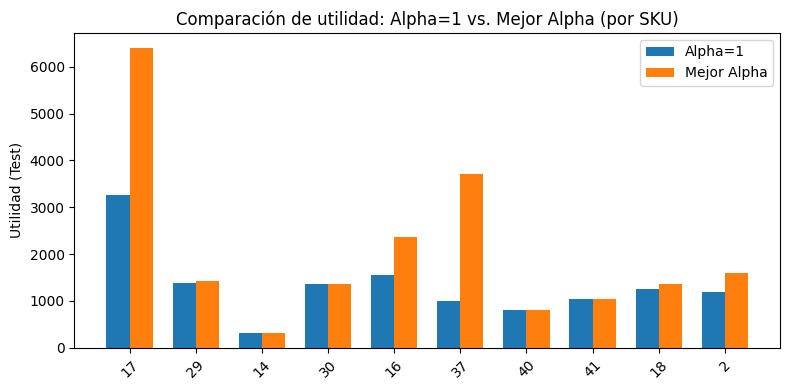

In [ ]:

# ----------------------------------------------------------------------------
# 5. Proceso principal
# ----------------------------------------------------------------------------

def main():
    # A) Cargar datos
    df_ventas = pd.read_csv("/content/Resumen_Pivotado.csv")
    df_tiempo_vida = pd.read_csv("/content/Tiempo_vida.csv")

    columnas_semanales = list(df_ventas.columns[1:])  # Suponiendo la primera col es 'Sku'

    # B) Limpiar columnas de precio/costo
    df_tiempo_vida = limpiar_columnas_precio_costo(df_tiempo_vida)

    # C) Expandir a diario
    df_ventas_diarias, columnas_diarias = expandir_a_diario(df_ventas, columnas_semanales)
    total_dias = len(columnas_diarias)

    print("Total de días expandido:", total_dias)

    # D) Dividir en TRAIN, VALIDATION, TEST
    #    Por ejemplo, 50% train, 20% valid, 30% test
    porc_train = 0.04
    porc_val   = 0.5435
    porc_test  = 0.4155
    # Ajustar si deseas otras proporciones, pero deben sumar ~1.

    dias_train = int(total_dias * porc_train)
    dias_val   = int(total_dias * porc_val)
    dias_test  = total_dias - dias_train - dias_val

    # Segmentos:
    # - Train: [0, dias_train)
    # - Validation: [dias_train, dias_train + dias_val)
    # - Test: [dias_train + dias_val, total_dias)

    print(f"Train: {dias_train} días, Valid: {dias_val} días, Test: {dias_test} días")

    # E) Seleccionar algunos SKUs o todos
    np.random.seed(42)
    skus_disponibles = df_tiempo_vida["Sku"].tolist()
    skus_seleccionados = random.sample(skus_disponibles, 10)  # 10 SKUs

    print("Número de los skus seleccionados")
    print(len(skus_seleccionados))
    print(skus_seleccionados)

    # Parámetros
    N_semanas = 4
    alphas = np.arange(-3, 6.5, 0.5)

    resultados_skus = []

    # F) Bucle por cada SKU
    for sku_sel in skus_seleccionados:
        info_sku = df_tiempo_vida.loc[df_tiempo_vida["Sku"] == sku_sel].iloc[0]

        # 1) Buscar el mejor alpha usando SOLO la parte de VALIDATION
        mejor_alpha = None
        mejor_utilidad_val = -9999999

        for alpha in alphas:
            utilidad_val = simular_inventario_y_utilidad_sku(
                df_ventas_diarias=df_ventas_diarias,
                df_tiempo_vida_sku=info_sku,
                columnas_diarias=columnas_diarias,
                inicio=dias_train,              # Arranca validación
                longitud_simulacion=dias_val,  # Solo la ventana de validación
                N_semanas=N_semanas,
                alpha=alpha
            )
            if utilidad_val > mejor_utilidad_val:
                mejor_utilidad_val = utilidad_val
                mejor_alpha = alpha

        # 2) Evaluar en TEST usando el alpha óptimo
        utilidad_mejor_alpha = simular_inventario_y_utilidad_sku(
            df_ventas_diarias=df_ventas_diarias,
            df_tiempo_vida_sku=info_sku,
            columnas_diarias=columnas_diarias,
            inicio=dias_train + dias_val,  # Empieza donde acaba valid
            longitud_simulacion=dias_test, # Ventana de test
            N_semanas=N_semanas,
            alpha=mejor_alpha
        )

        # 3) Comparar con alpha = 1 en TEST
        utilidad_alpha_1 = simular_inventario_y_utilidad_sku(
            df_ventas_diarias=df_ventas_diarias,
            df_tiempo_vida_sku=info_sku,
            columnas_diarias=columnas_diarias,
            inicio=dias_train + dias_val,
            longitud_simulacion=dias_test,
            N_semanas=N_semanas,
            alpha=1.0
        )

        resultados_skus.append({
            "Sku": sku_sel,
            "MejorAlpha": mejor_alpha,
            "UtilidadVal": mejor_utilidad_val,
            "UtilidadMejorAlphaTest": utilidad_mejor_alpha,
            "UtilidadAlpha1Test": utilidad_alpha_1
        })

    # G) Mostrar resultados
    df_resultados = pd.DataFrame(resultados_skus)
    print("\nResultados para los SKUs seleccionados:\n")
    print(df_resultados)

    # H) Calcular y mostrar la utilidad total en test
    total_optimo = df_resultados["UtilidadMejorAlphaTest"].sum()
    total_alpha1 = df_resultados["UtilidadAlpha1Test"].sum()

    print("\nUtilidad total en TEST con alpha=1:", total_alpha1)
    print("Utilidad total en TEST con alpha óptimo (por SKU):", total_optimo)

    # I) Graficar la comparación (opcional)
    fig, ax = plt.subplots(figsize=(8,4))
    x = np.arange(len(df_resultados))
    bar_width = 0.35

    ax.bar(x - bar_width/2, df_resultados["UtilidadAlpha1Test"], bar_width, label="Alpha=1")
    ax.bar(x + bar_width/2, df_resultados["UtilidadMejorAlphaTest"], bar_width, label="Mejor Alpha")

    ax.set_xticks(x)
    ax.set_xticklabels(df_resultados["Sku"], rotation=45)
    ax.set_ylabel("Utilidad (Test)")
    ax.set_title("Comparación de utilidad: Alpha=1 vs. Mejor Alpha (por SKU)")
    ax.legend()
    plt.tight_layout()
    plt.show()

    """
    # I) Graficar la comparación de la utilidad total
    plt.figure(figsize=(6,4))
    plt.bar(["Alpha=1", "Alpha Optimizado"], [total_alpha1, total_optimo], color=['blue','green'])
    plt.xlabel("Estrategia")
    plt.ylabel("Utilidad Total en Test")
    plt.title("Comparación de Utilidad en Test: Alpha=1 vs. Alpha Óptimo")
    for i, val in enumerate([total_alpha1, total_optimo]):
        plt.text(i, val + 0.03*abs(val), f"{val:.2f}", ha='center', va='bottom', fontsize=5)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()"""

if __name__ == "__main__":
    main()


### Test mayo 2023 - mayo 2024

Total de días expandido: 875
Train: 35 días, Valid: 475 días, Test: 365 días
Número de los skus seleccionados
50
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

Resultados para los SKUs seleccionados:

    Sku  MejorAlpha  UtilidadVal  UtilidadMejorAlphaTest  UtilidadAlpha1Test
0     1         6.0  8748.334286             7403.400000         1901.120000
1     2         2.5  2449.025714             1588.240000         1187.280000
2     3         0.0  2908.525714             2225.390000         2225.390000
3     4         1.0  1378.811429              674.940000          674.940000
4     5         4.5  4306.680000             4644.100000         1679.600000
5     6         0.0  1787.730000             1335.660000         1335.660000
6     7         5.0  7538.721429            11451.100000         5744.200000
7     8         0.0  1054.894286     

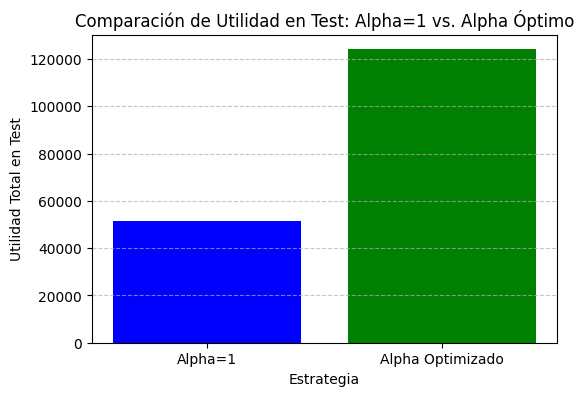

In [ ]:
# ----------------------------------------------------------------------------
# 5. Proceso principal
# ----------------------------------------------------------------------------

def main():
    # A) Cargar datos
    df_ventas = pd.read_csv("/content/Resumen_Pivotado.csv")
    df_tiempo_vida = pd.read_csv("/content/Tiempo_vida.csv")

    columnas_semanales = list(df_ventas.columns[1:])  # Suponiendo la primera col es 'Sku'

    # B) Limpiar columnas de precio/costo
    df_tiempo_vida = limpiar_columnas_precio_costo(df_tiempo_vida)

    # C) Expandir a diario
    df_ventas_diarias, columnas_diarias = expandir_a_diario(df_ventas, columnas_semanales)
    total_dias = len(columnas_diarias)

    print("Total de días expandido:", total_dias)

    # D) Dividir en TRAIN, VALIDATION, TEST
    #    Por ejemplo, 50% train, 20% valid, 30% test
    porc_train = 0.04
    porc_val   = 0.5435
    porc_test  = 0.4155
    # Ajustar si deseas otras proporciones, pero deben sumar ~1.

    dias_train = int(total_dias * porc_train)
    dias_val   = int(total_dias * porc_val)
    dias_test  = total_dias - dias_train - dias_val

    # Segmentos:
    # - Train: [0, dias_train)
    # - Validation: [dias_train, dias_train + dias_val)
    # - Test: [dias_train + dias_val, total_dias)

    print(f"Train: {dias_train} días, Valid: {dias_val} días, Test: {dias_test} días")

    # E) Seleccionar algunos SKUs o todos
    np.random.seed(42)
    skus_disponibles = df_tiempo_vida["Sku"].tolist()
    skus_seleccionados = skus_disponibles  # Todos los skus

    print("Número de los skus seleccionados")
    print(len(skus_seleccionados))
    print(skus_seleccionados)

    # Parámetros
    N_semanas = 4
    alphas = np.arange(-3, 6.5, 0.5)

    resultados_skus = []

    # F) Bucle por cada SKU
    for sku_sel in skus_seleccionados:
        info_sku = df_tiempo_vida.loc[df_tiempo_vida["Sku"] == sku_sel].iloc[0]

        # 1) Buscar el mejor alpha usando SOLO la parte de VALIDATION
        mejor_alpha = None
        mejor_utilidad_val = -9999999

        for alpha in alphas:
            utilidad_val = simular_inventario_y_utilidad_sku(
                df_ventas_diarias=df_ventas_diarias,
                df_tiempo_vida_sku=info_sku,
                columnas_diarias=columnas_diarias,
                inicio=dias_train,              # Arranca validación
                longitud_simulacion=dias_val,  # Solo la ventana de validación
                N_semanas=N_semanas,
                alpha=alpha
            )
            if utilidad_val > mejor_utilidad_val:
                mejor_utilidad_val = utilidad_val
                mejor_alpha = alpha

        # 2) Evaluar en TEST usando el alpha óptimo
        utilidad_mejor_alpha = simular_inventario_y_utilidad_sku(
            df_ventas_diarias=df_ventas_diarias,
            df_tiempo_vida_sku=info_sku,
            columnas_diarias=columnas_diarias,
            inicio=dias_train + dias_val,  # Empieza donde acaba valid
            longitud_simulacion=dias_test, # Ventana de test
            N_semanas=N_semanas,
            alpha=mejor_alpha
        )

        # 3) Comparar con alpha = 1 en TEST
        utilidad_alpha_1 = simular_inventario_y_utilidad_sku(
            df_ventas_diarias=df_ventas_diarias,
            df_tiempo_vida_sku=info_sku,
            columnas_diarias=columnas_diarias,
            inicio=dias_train + dias_val,
            longitud_simulacion=dias_test,
            N_semanas=N_semanas,
            alpha=1.0
        )

        resultados_skus.append({
            "Sku": sku_sel,
            "MejorAlpha": mejor_alpha,
            "UtilidadVal": mejor_utilidad_val,
            "UtilidadMejorAlphaTest": utilidad_mejor_alpha,
            "UtilidadAlpha1Test": utilidad_alpha_1
        })

    # G) Mostrar resultados
    df_resultados = pd.DataFrame(resultados_skus)
    print("\nResultados para los SKUs seleccionados:\n")
    print(df_resultados)

    # H) Calcular y mostrar la utilidad total en test
    total_optimo = df_resultados["UtilidadMejorAlphaTest"].sum()
    total_alpha1 = df_resultados["UtilidadAlpha1Test"].sum()

    print("\nUtilidad total en TEST con alpha=1:", total_alpha1)
    print("Utilidad total en TEST con alpha óptimo (por SKU):", total_optimo)

    """# I) Graficar la comparación (opcional)
    fig, ax = plt.subplots(figsize=(8,4))
    x = np.arange(len(df_resultados))
    bar_width = 0.35

    ax.bar(x - bar_width/2, df_resultados["UtilidadAlpha1Test"], bar_width, label="Alpha=1")
    ax.bar(x + bar_width/2, df_resultados["UtilidadMejorAlphaTest"], bar_width, label="Mejor Alpha")

    ax.set_xticks(x)
    ax.set_xticklabels(df_resultados["Sku"], rotation=45)
    ax.set_ylabel("Utilidad (Test)")
    ax.set_title("Comparación de utilidad: Alpha=1 vs. Mejor Alpha (por SKU)")
    ax.legend()
    plt.tight_layout()
    plt.show()"""


    # I) Graficar la comparación de la utilidad total
    plt.figure(figsize=(6,4))
    plt.bar(["Alpha=1", "Alpha Optimizado"], [total_alpha1, total_optimo], color=['blue','green'])
    plt.xlabel("Estrategia")
    plt.ylabel("Utilidad Total en Test")
    plt.title("Comparación de Utilidad en Test: Alpha=1 vs. Alpha Óptimo")
    #for i, val in enumerate([total_alpha1, total_optimo]):
        #plt.text(i, val + 0.03*abs(val), f"{val:.2f}", ha='center', va='bottom', fontsize=5)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt


In [ ]:

# =============================================================================
# Funciones Auxiliares
# =============================================================================

def redondear_al_surtido(cantidad, tamanio_surtido):
    """
    Redondea hacia arriba al múltiplo más cercano de tamanio_surtido.
    """
    if cantidad <= 0:
        return 0
    return int(math.ceil(cantidad / tamanio_surtido) * tamanio_surtido)

def calcular_promedio_movil(ventas_history, sku, dia_actual_idx, N_semanas, columnas_diarias):
    """
    Calcula el promedio de demanda de los últimos N_semanas (N_semanas*7 días) para el SKU.
    """
    dias_a_revisar = N_semanas * 7
    idx_inicial = max(0, dia_actual_idx - dias_a_revisar)
    columnas_previas = columnas_diarias[idx_inicial: dia_actual_idx]

    demanda_hist = ventas_history.loc[ventas_history["Sku"] == sku, columnas_previas]
    if demanda_hist.shape[1] == 0:
        return 0.0
    return demanda_hist.values.flatten().mean()

def simular_inventario_y_utilidad_sku(df_ventas_diarias, df_tiempo_vida_sku, columnas_diarias, inicio, longitud_simulacion, N_semanas, alpha):
    """
    Simula para UN SKU la evolución del inventario y calcula la utilidad obtenida en la ventana
    [inicio, inicio + longitud_simulacion) usando la estrategia:
    pedido = promedio móvil (últimas N_semanas) + alpha, redondeado al tamaño de surtido.

    Se considera que se hace pedido cada 7 días y que hay caducidad (según TiempoVida en días).
    """
    sku = df_tiempo_vida_sku["Sku"]
    precio = df_tiempo_vida_sku["Precio"]
    costo = df_tiempo_vida_sku["Costo"]
    tiempo_vida_dias = df_tiempo_vida_sku["TiempoVida"]
    tamanio_surtido = df_tiempo_vida_sku["TamañoSurtido"]

    inventario = []  # Cada elemento es (cantidad, dia_llegada)
    ventas_history = df_ventas_diarias.copy()
    fin = inicio + longitud_simulacion
    utilidad_total = 0.0

    for dia_idx in range(inicio, fin):
        # 1) Día de pedido (cada 7 días, asumiendo que día 0 es lunes)
        if dia_idx % 7 == 0:
            demanda_prom = calcular_promedio_movil(ventas_history, sku, dia_idx, N_semanas, columnas_diarias)
            pedido_sugerido = demanda_prom + alpha
            pedido_final = redondear_al_surtido(pedido_sugerido, tamanio_surtido)
            if pedido_final > 0:
                inventario.append((pedido_final, dia_idx))

        # 2) Ventas del día
        col_dia = columnas_diarias[dia_idx]
        demanda_dia = ventas_history.loc[ventas_history["Sku"] == sku, col_dia].values[0]

        # 3) Eliminar lotes caducados
        lotes_vigentes = []
        unidades_caducadas = 0
        for (cant, dia_llegada) in inventario:
            if (dia_idx - dia_llegada) >= tiempo_vida_dias:
                unidades_caducadas += cant
            else:
                lotes_vigentes.append((cant, dia_llegada))
        inventario = lotes_vigentes

        # 4) Ventas en función de unidades disponibles
        unidades_disponibles = sum(l[0] for l in inventario)
        unidades_vendidas = min(demanda_dia, unidades_disponibles)

        # 5) Calcular utilidad del día
        ganancia_ventas = unidades_vendidas * (precio - costo)
        costo_merma = unidades_caducadas * costo
        utilidad_dia = ganancia_ventas - costo_merma
        utilidad_total += utilidad_dia

        # 6) Actualizar inventario tras la venta
        uds_por_vender = unidades_vendidas
        lotes_actualizados = []
        for (cant, dia_llegada) in inventario:
            if uds_por_vender > 0:
                if cant <= uds_por_vender:
                    uds_por_vender -= cant
                else:
                    nuevo_cant = cant - uds_por_vender
                    uds_por_vender = 0
                    lotes_actualizados.append((nuevo_cant, dia_llegada))
            else:
                lotes_actualizados.append((cant, dia_llegada))
        inventario = lotes_actualizados

        # 7) Actualizar ventas realizadas en la copia
        ventas_history.loc[ventas_history["Sku"] == sku, col_dia] = unidades_vendidas

    return utilidad_total

In [ ]:

# =============================================================================
# Funciones Auxiliares
# =============================================================================

def redondear_al_surtido(cantidad, tamanio_surtido):
    """
    Redondea hacia arriba al múltiplo más cercano de tamanio_surtido.
    """
    if cantidad <= 0:
        return 0
    return int(math.ceil(cantidad / tamanio_surtido) * tamanio_surtido)

def calcular_promedio_movil(ventas_history, sku, dia_actual_idx, N_semanas, columnas_diarias):
    """
    Calcula el promedio de demanda de los últimos N_semanas (N_semanas*7 días) para el SKU.
    """
    dias_a_revisar = N_semanas * 7
    idx_inicial = max(0, dia_actual_idx - dias_a_revisar)
    columnas_previas = columnas_diarias[idx_inicial: dia_actual_idx]

    demanda_hist = ventas_history.loc[ventas_history["Sku"] == sku, columnas_previas]
    if demanda_hist.shape[1] == 0:
        return 0.0
    return demanda_hist.values.flatten().mean()

def simular_inventario_y_utilidad_sku(df_ventas_diarias, df_tiempo_vida_sku, columnas_diarias, inicio, longitud_simulacion, N_semanas, alpha):
    """
    Simula para UN SKU la evolución del inventario y calcula la utilidad obtenida en la ventana
    [inicio, inicio + longitud_simulacion) usando la estrategia:
    pedido = promedio móvil (últimas N_semanas) + alpha, redondeado al tamaño de surtido.

    Se considera que se hace pedido cada 7 días y que hay caducidad (según TiempoVida en días).
    """
    sku = df_tiempo_vida_sku["Sku"]
    precio = df_tiempo_vida_sku["Precio"]
    costo = df_tiempo_vida_sku["Costo"]
    tiempo_vida_dias = df_tiempo_vida_sku["TiempoVida"]
    tamanio_surtido = df_tiempo_vida_sku["TamañoSurtido"]

    inventario = []  # Cada elemento es (cantidad, dia_llegada)
    ventas_history = df_ventas_diarias.copy()
    fin = inicio + longitud_simulacion
    utilidad_total = 0.0

    for dia_idx in range(inicio, fin):
        # 1) Día de pedido (cada 7 días, asumiendo que día 0 es lunes)
        if dia_idx % 7 == 0:
            demanda_prom = calcular_promedio_movil(ventas_history, sku, dia_idx, N_semanas, columnas_diarias)
            pedido_sugerido = demanda_prom + alpha
            pedido_final = redondear_al_surtido(pedido_sugerido, tamanio_surtido)
            if pedido_final > 0:
                inventario.append((pedido_final, dia_idx))

        # 2) Ventas del día
        col_dia = columnas_diarias[dia_idx]
        demanda_dia = ventas_history.loc[ventas_history["Sku"] == sku, col_dia].values[0]

        # 3) Eliminar lotes caducados
        lotes_vigentes = []
        unidades_caducadas = 0
        for (cant, dia_llegada) in inventario:
            if (dia_idx - dia_llegada) >= tiempo_vida_dias:
                unidades_caducadas += cant
            else:
                lotes_vigentes.append((cant, dia_llegada))
        inventario = lotes_vigentes

        # 4) Ventas en función de unidades disponibles
        unidades_disponibles = sum(l[0] for l in inventario)
        unidades_vendidas = min(demanda_dia, unidades_disponibles)

        # 5) Calcular utilidad del día
        ganancia_ventas = unidades_vendidas * (precio - costo)
        costo_merma = unidades_caducadas * costo
        utilidad_dia = ganancia_ventas - costo_merma
        utilidad_total += utilidad_dia

        # 6) Actualizar inventario tras la venta
        uds_por_vender = unidades_vendidas
        lotes_actualizados = []
        for (cant, dia_llegada) in inventario:
            if uds_por_vender > 0:
                if cant <= uds_por_vender:
                    uds_por_vender -= cant
                else:
                    nuevo_cant = cant - uds_por_vender
                    uds_por_vender = 0
                    lotes_actualizados.append((nuevo_cant, dia_llegada))
            else:
                lotes_actualizados.append((cant, dia_llegada))
        inventario = lotes_actualizados

        # 7) Actualizar ventas realizadas en la copia
        ventas_history.loc[ventas_history["Sku"] == sku, col_dia] = unidades_vendidas

    return utilidad_total

In [ ]:


# =============================================================================
# Funciones Principales: train_algoritm y test_algoritm
# =============================================================================

def train_algoritm(df_ventas_diarias, df_tiempo_vida, columnas_diarias, train_ratio=0.04, val_ratio=0.54, N_semanas=4, alphas=np.arange(-3, 6.5, 0.5)):
    """
    Entrena el algoritmo para cada SKU buscando el alpha óptimo que maximice la utilidad
    en la ventana de validación.

    Parámetros:
      - df_ventas_diarias: DataFrame con las ventas diarias (ya procesado), que incluye la columna 'Sku'.
      - df_tiempo_vida: DataFrame con la información del producto (debe tener 'Sku', 'Precio', 'Costo', 'TiempoVida' y 'TamañoSurtido').
      - columnas_diarias: Lista ordenada de nombres de columnas diarias.
      - train_ratio: Proporción del total de días que se asigna a entrenamiento (se usa para definir el inicio de validación).
      - val_ratio: Proporción del total de días asignada a validación.
      - N_semanas: Número de semanas para el cálculo del promedio móvil.
      - alphas: Rango de valores a probar para el ajuste.

    Retorna:
      - DataFrame con columnas: "Sku", "MejorAlpha" y "UtilidadVal" (utilidad en validación).

    Además, genera una gráfica de barras que muestra la utilidad en validación para cada SKU con su mejor alpha.
    """
    total_dias = len(columnas_diarias)
    dias_train = int(total_dias * train_ratio)
    dias_val = int(total_dias * val_ratio)

    resultados = []
    for sku in df_tiempo_vida["Sku"].unique():
        info_sku = df_tiempo_vida.loc[df_tiempo_vida["Sku"] == sku].iloc[0]
        mejor_alpha = None
        mejor_utilidad_val = -np.inf

        for alpha in alphas:
            utilidad_val = simular_inventario_y_utilidad_sku(
                df_ventas_diarias, info_sku, columnas_diarias,
                inicio=dias_train,
                longitud_simulacion=dias_val,
                N_semanas=N_semanas,
                alpha=alpha
            )
            if utilidad_val > mejor_utilidad_val:
                mejor_utilidad_val = utilidad_val
                mejor_alpha = alpha

        resultados.append({
            "Sku": sku,
            "MejorAlpha": mejor_alpha,
            "UtilidadVal": mejor_utilidad_val
        })
    df_resultados_train = pd.DataFrame(resultados)

    # Gráfica: Utilidad en validación por SKU
    plt.figure(figsize=(8,4))
    plt.bar(df_resultados_train["Sku"], df_resultados_train["UtilidadVal"], color='skyblue')
    plt.xlabel("SKU")
    plt.ylabel("Utilidad en Validación")
    plt.title("Utilidad en Validación con Mejor Alpha por SKU")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df_resultados_train

def test_algoritm(df_ventas_diarias, df_tiempo_vida, columnas_diarias, train_ratio=0.04, val_ratio=0.54, N_semanas=4, best_alphas=None):
    """
    Evalúa la estrategia en la ventana de TEST para cada SKU comparando:
      - La estrategia optimizada (usando el mejor alpha obtenido en train_algoritm).
      - La estrategia propuesta (fijando alpha=1).

    Parámetros:
      - df_ventas_diarias: DataFrame con las ventas diarias ya procesadas.
      - df_tiempo_vida: DataFrame con la información del producto.
      - columnas_diarias: Lista ordenada de columnas diarias.
      - train_ratio: Proporción de días asignada a entrenamiento.
      - val_ratio: Proporción de días asignada a validación.
      - N_semanas: Número de semanas para el promedio móvil.
      - best_alphas: DataFrame obtenido de train_algoritm con las columnas "Sku" y "MejorAlpha".
                      Si no se proporciona, se usará alpha=1.0 para todos.

    Retorna:
      - DataFrame con columnas: "Sku", "MejorAlpha", "UtilidadMejorAlphaTest" y "UtilidadAlpha1Test".

    Además, genera dos gráficas de barras:
      1. Comparación por SKU entre la utilidad en test con alpha=1 y con el alpha optimizado.
      2. Comparación global de la utilidad total en test entre ambas estrategias.
    """
    total_dias = len(columnas_diarias)
    dias_train = int(total_dias * train_ratio)
    dias_val = int(total_dias * val_ratio)
    dias_test = total_dias - dias_train - dias_val

    resultados = []
    for sku in df_tiempo_vida["Sku"].unique():
        info_sku = df_tiempo_vida.loc[df_tiempo_vida["Sku"] == sku].iloc[0]
        # Si se proporcionaron los mejores alphas, se usa el correspondiente; de lo contrario, se usa 1.0
        if best_alphas is not None and sku in best_alphas["Sku"].values:
            best_alpha = best_alphas.loc[best_alphas["Sku"] == sku, "MejorAlpha"].values[0]
        else:
            best_alpha = 1.0

        utilidad_mejor_alpha = simular_inventario_y_utilidad_sku(
            df_ventas_diarias, info_sku, columnas_diarias,
            inicio=dias_train + dias_val,
            longitud_simulacion=dias_test,
            N_semanas=N_semanas,
            alpha=best_alpha
        )

        utilidad_alpha1 = simular_inventario_y_utilidad_sku(
            df_ventas_diarias, info_sku, columnas_diarias,
            inicio=dias_train + dias_val,
            longitud_simulacion=dias_test,
            N_semanas=N_semanas,
            alpha=1.0
        )

        resultados.append({
            "Sku": sku,
            "MejorAlpha": best_alpha,
            "UtilidadMejorAlphaTest": utilidad_mejor_alpha,
            "UtilidadAlpha1Test": utilidad_alpha1
        })
    df_resultados_test = pd.DataFrame(resultados)

    # Gráfica 1: Comparación por SKU
    x = np.arange(len(df_resultados_test))
    bar_width = 0.35
    plt.figure(figsize=(10,5))
    plt.bar(x - bar_width/2, df_resultados_test["UtilidadAlpha1Test"], bar_width, label="Alpha = 1")
    plt.bar(x + bar_width/2, df_resultados_test["UtilidadMejorAlphaTest"], bar_width, label="Mejor Alpha")
    plt.xticks(x, df_resultados_test["Sku"], rotation=45)
    plt.xlabel("SKU")
    plt.ylabel("Utilidad en Test")
    plt.title("Comparación de Utilidad en Test: Alpha=1 vs. Mejor Alpha")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Gráfica 2: Comparación global
    total_alpha1 = df_resultados_test["UtilidadAlpha1Test"].sum()
    total_optimo = df_resultados_test["UtilidadMejorAlphaTest"].sum()
    plt.figure(figsize=(6,4))
    plt.bar(["Alpha = 1", "Alpha Optimizado"], [total_alpha1, total_optimo], color=['blue','green'])
    plt.xlabel("Estrategia")
    plt.ylabel("Utilidad Total en Test")
    plt.title("Utilidad Total en Test: Alpha=1 vs. Alpha Optimizado")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return df_resultados_test

# =============================================================================
# Ejemplo de uso:
# =============================================================================
# Supongamos que ya cuentas con:
#  - df_ventas_diarias: DataFrame con la columna 'Sku' y las columnas diarias (por ejemplo: '2023-05_d1', '2023-05_d2', ...)
#  - df_tiempo_vida: DataFrame con la información de cada producto, incluyendo 'Sku', 'Precio', 'Costo', 'TiempoVida' y 'TamañoSurtido'
#  - columnas_diarias: Lista ordenada de nombres de columnas que representan los días de venta.
#
# Ejemplo:
# df_train = train_algoritm(df_ventas_diarias, df_tiempo_vida, columnas_diarias, train_ratio=0.04, val_ratio=0.54, N_semanas=4)
# df_test = test_algoritm(df_ventas_diarias, df_tiempo_vida, columnas_diarias, train_ratio=0.04, val_ratio=0.54, N_semanas=4, best_alphas=df_train)
